Dataset shape: (300, 4)

First few rows of the dataset:
   Feature 1  Feature 2  Feature 3  Target
0   0.872071  -0.671159  -0.354963       0
1   0.882482   0.098216  -0.785205       1
2   2.410259   2.934601  -2.836201       1
3  -2.325432   0.836658  -1.520111       0
4   1.828962   2.035318  -1.680292       1

Class distribution:
Target
0    152
1    148
Name: count, dtype: int64

Model Coefficients: [[1.50321195 0.35244583 0.24327456]]
Intercept: [-0.18486857]

Accuracy: 0.7222222222222222

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        41
           1       0.82      0.63      0.71        49

    accuracy                           0.72        90
   macro avg       0.73      0.73      0.72        90
weighted avg       0.74      0.72      0.72        90


Confusion Matrix:
[[34  7]
 [18 31]]


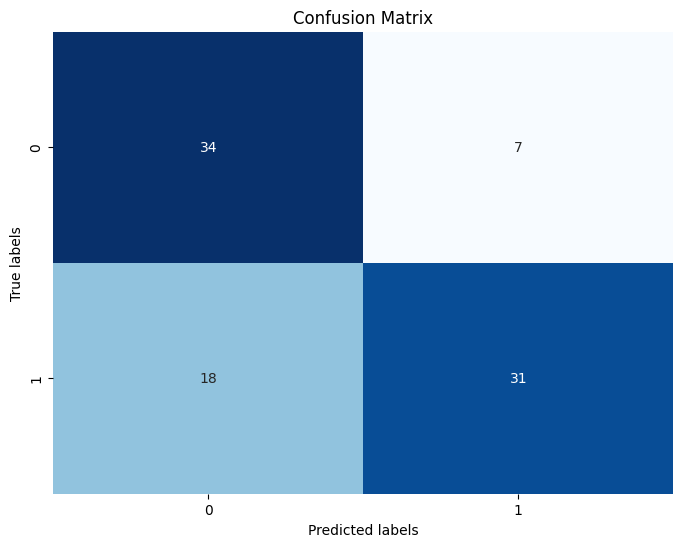

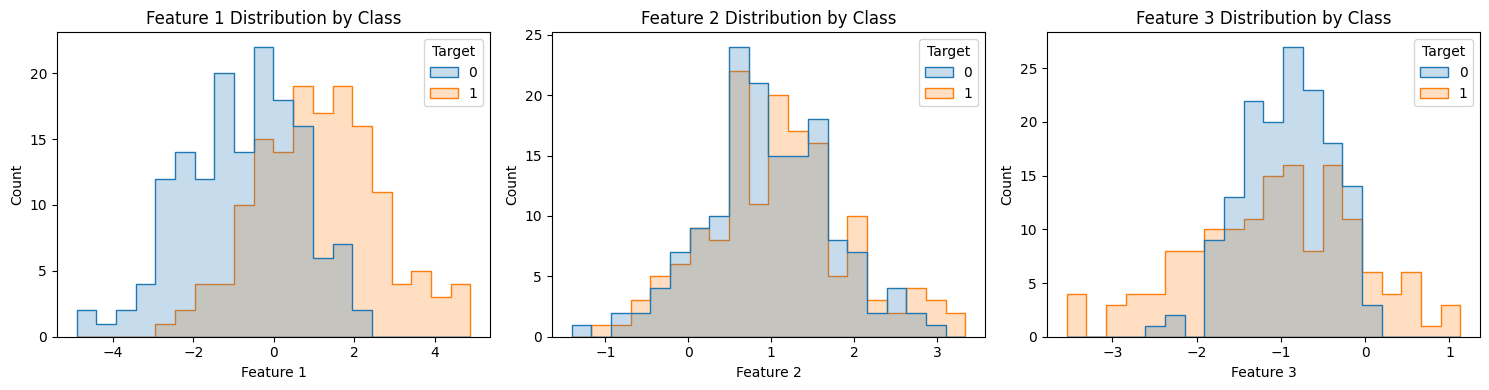

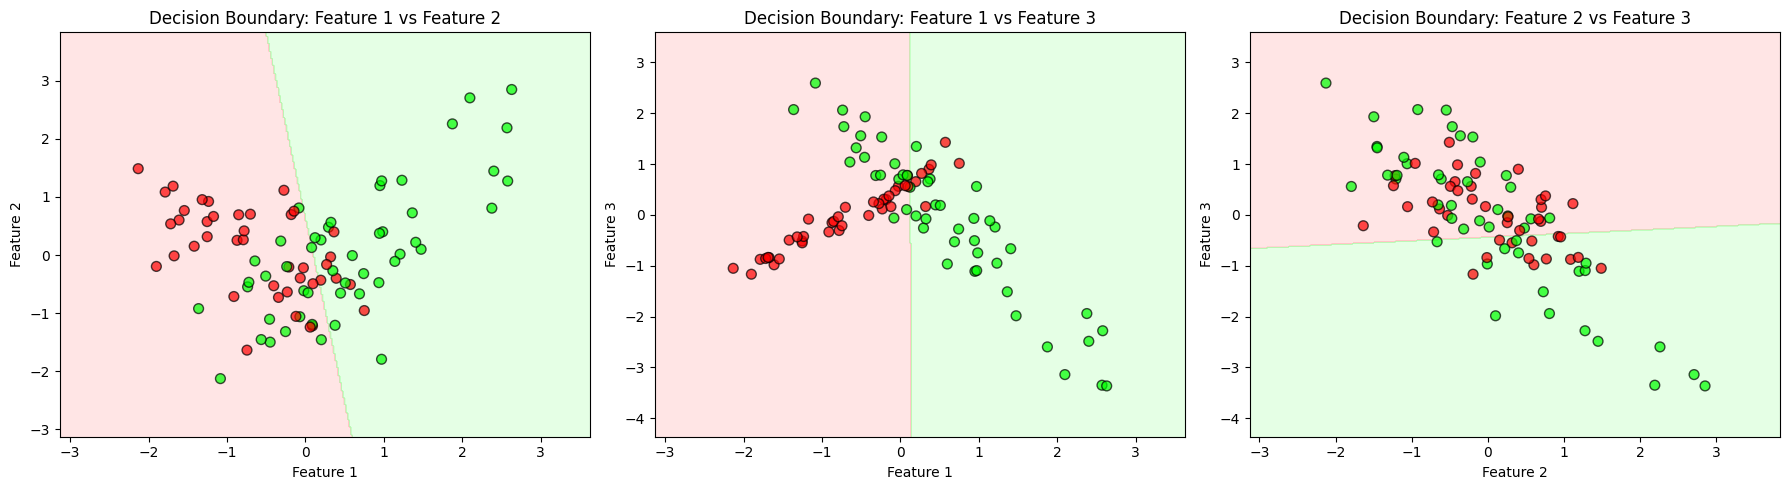

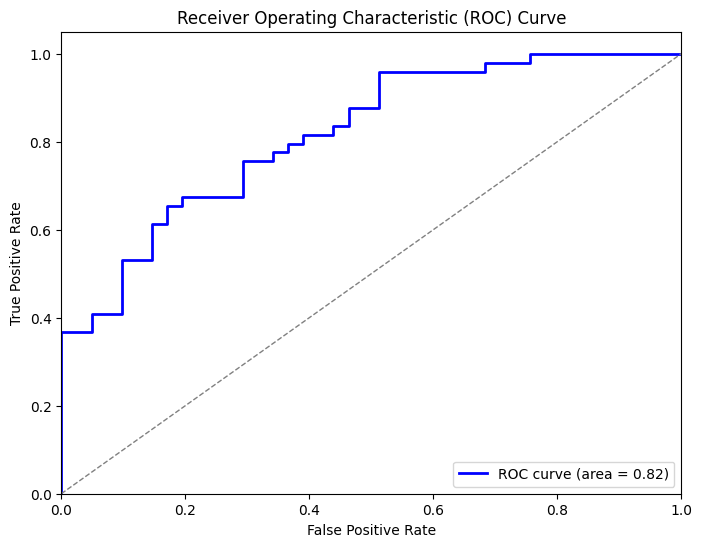

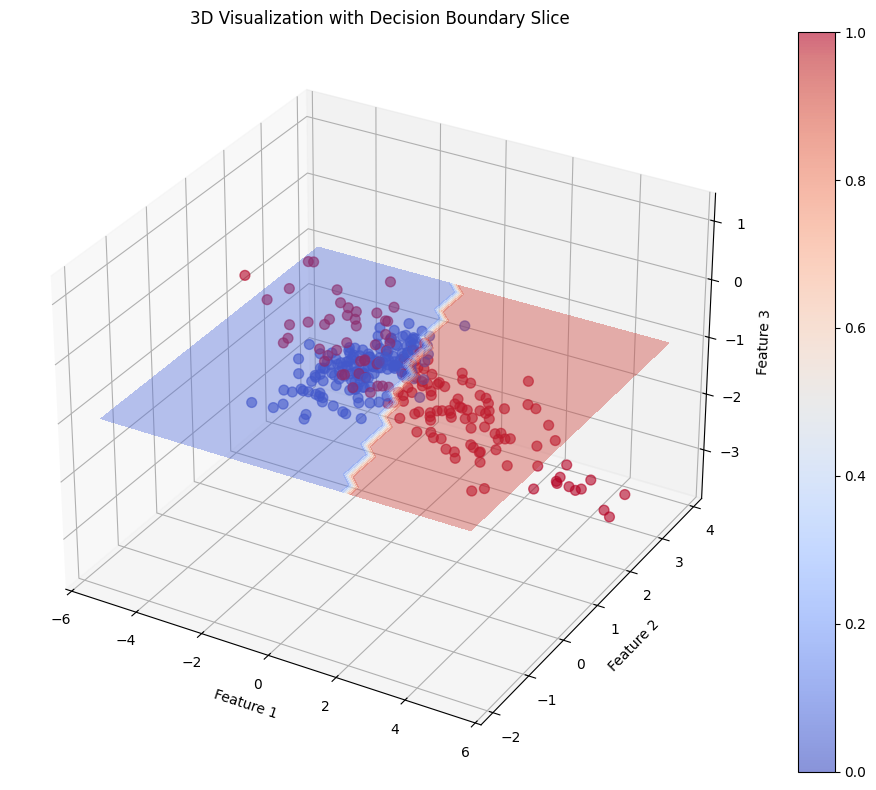

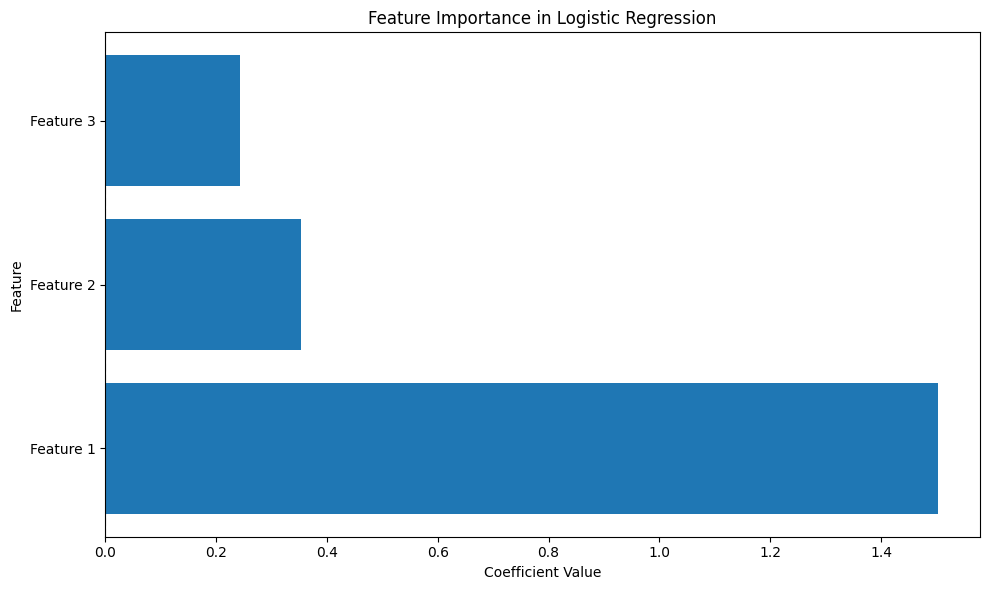

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset with 3 features
X, y = make_classification(
    n_samples=300, 
    n_features=3,
    n_redundant=0,
    n_informative=3,
    random_state=42,
    n_clusters_per_class=1
)

# Create a DataFrame for better understanding
feature_names = ['Feature 1', 'Feature 2', 'Feature 3']
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y

print("Dataset shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

print("\nClass distribution:")
print(df['Target'].value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Model evaluation
print("\nModel Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize feature distributions by class
plt.figure(figsize=(15, 4))

for i, feature in enumerate(feature_names):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feature, hue='Target', element='step', common_norm=False, bins=20)
    plt.title(f'{feature} Distribution by Class')
    
plt.tight_layout()
plt.show()

# Create pairwise scatter plots for decision boundaries
# Since we can't visualize all 3 dimensions at once, we'll create pairwise plots
feature_pairs = [(0, 1), (0, 2), (1, 2)]
pair_names = [('Feature 1', 'Feature 2'), ('Feature 1', 'Feature 3'), ('Feature 2', 'Feature 3')]

plt.figure(figsize=(18, 5))

for i, (feat_idx1, feat_idx2) in enumerate(feature_pairs):
    # Extract the two features we're plotting
    X_pair = X[:, [feat_idx1, feat_idx2]]
    X_pair_train, X_pair_test, y_train_pair, y_test_pair = train_test_split(
        X_pair, y, test_size=0.3, random_state=42
    )
    
    # Scale these two features
    scaler_pair = StandardScaler()
    X_pair_train_scaled = scaler_pair.fit_transform(X_pair_train)
    X_pair_test_scaled = scaler_pair.transform(X_pair_test)
    
    # Train a logistic regression model on just these two features
    model_pair = LogisticRegression(random_state=42)
    model_pair.fit(X_pair_train_scaled, y_train_pair)
    
    # Create a meshgrid for plotting the decision boundary
    h = 0.02  # Step size in the mesh
    x_min, x_max = X_pair_test_scaled[:, 0].min() - 1, X_pair_test_scaled[:, 0].max() + 1
    y_min, y_max = X_pair_test_scaled[:, 1].min() - 1, X_pair_test_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions on the meshgrid
    Z = model_pair.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.subplot(1, 3, i+1)
    
    # Plot the decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    
    # Plot the testing points
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
    plt.scatter(X_pair_test_scaled[:, 0], X_pair_test_scaled[:, 1], c=y_test_pair, 
                cmap=cmap_bold, edgecolor='k', s=50, alpha=0.7)
    
    plt.title(f'Decision Boundary: {pair_names[i][0]} vs {pair_names[i][1]}')
    plt.xlabel(pair_names[i][0])
    plt.ylabel(pair_names[i][1])
    
plt.tight_layout()
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 3D visualization (partial visualization of decision boundary with one feature fixed)
from mpl_toolkits.mplot3d import Axes3D

# We'll create a 3D visualization showing points and decision boundary at one slice
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

# Plot the 3D scatter of all points
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='coolwarm', s=50, alpha=0.6)

# Create a meshgrid for a slice at the mean value of feature 3
mean_feature3 = np.mean(X[:, 2])
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30), np.linspace(y_min, y_max, 30))
zz = np.full_like(xx, mean_feature3)

# Create grid points for prediction
grid = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
grid_scaled = scaler.transform(grid)

# Get predictions
Z = model.predict(grid_scaled)
Z = Z.reshape(xx.shape)

# Plot the decision surface at feature3=mean_feature3
ax.contourf(xx, yy, Z, zdir='z', offset=mean_feature3, cmap='coolwarm', alpha=0.4)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Visualization with Decision Boundary Slice')

plt.colorbar(scatter)
plt.tight_layout()
plt.show()

# Feature importance
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
})
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()